In [25]:
!pip -q install -U imbalanced-learn xgboost streamlit pyngrok joblib kagglehub seaborn cloudflared


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.3 MB/s eta 0:00:00


In [26]:
import kagglehub
import pandas as pd
import os

# Download dataset
dataset_path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("📁 Dataset downloaded to:", dataset_path)

# Find CSV file
for f in os.listdir(dataset_path):
    if f.endswith(".csv"):
        csv_file = os.path.join(dataset_path, f)

df = pd.read_csv(csv_file)
print("✅ Dataset Loaded")
print(df.shape)
print(df['Class'].value_counts())
df.head()


Using Colab cache for faster access to the 'creditcardfraud' dataset.
📁 Dataset downloaded to: /kaggle/input/creditcardfraud
✅ Dataset Loaded
(284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [27]:
print("Missing Values Check:\n", df.isnull().sum().sum())
fraud_rate = df['Class'].mean()*100
print(f"Fraud Percentage: {fraud_rate:.4f}%")

Missing Values Check:
 0
Fraud Percentage: 0.1727%


In [28]:
from sklearn.model_selection import train_test_split

X = df.drop("Class", axis=1)
y = df["Class"].astype(int)

# 70% Train, 30% Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 20% of Train → Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42
)

print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)


Train: (159491, 30) | Val: (39873, 30) | Test: (85443, 30)


In [29]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

model = Pipeline([
    ("scale", StandardScaler(with_mean=False)),
    ("smote", SMOTE(sampling_strategy=0.12, random_state=42)),
    ("clf", LogisticRegression(max_iter=600, class_weight='balanced'))
])

model.fit(X_train, y_train)

val_scores = model.predict_proba(X_val)[:,1]
print("Validation ROC-AUC:", roc_auc_score(y_val, val_scores))
print("Validation PR-AUC :", average_precision_score(y_val, val_scores))


Validation ROC-AUC: 0.9906767799900672
Validation PR-AUC : 0.7640750119548747


In [30]:
from sklearn.metrics import precision_recall_curve

ps, rs, ts = precision_recall_curve(y_val, val_scores)
f1s = (2*ps*rs)/(ps+rs+1e-9)
best_index = f1s.argmax()
threshold = ts[best_index]

print("✅ Best Threshold =", threshold)


✅ Best Threshold = 0.9999999995065192


In [31]:
from sklearn.metrics import classification_report, confusion_matrix

test_scores = model.predict_proba(X_test)[:,1]
y_pred_test = (test_scores >= threshold).astype(int)

print(classification_report(y_test, y_pred_test, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     85295
           1     0.8672    0.7500    0.8043       148

    accuracy                         0.9994     85443
   macro avg     0.9334    0.8749    0.9020     85443
weighted avg     0.9993    0.9994    0.9993     85443

Confusion Matrix:
 [[85278    17]
 [   37   111]]


In [32]:
import json, numpy as np, os
from joblib import dump

os.makedirs("artifacts", exist_ok=True)

dump(model, "artifacts/model.joblib")

with open("artifacts/metadata.json", "w") as f:
    json.dump({"threshold": float(threshold), "features": list(X.columns)}, f, indent=2)

np.save("artifacts/y_test.npy", y_test.values)
np.save("artifacts/test_scores.npy", test_scores)

print("✅ Artifacts Saved in /content/artifacts")


✅ Artifacts Saved in /content/artifacts


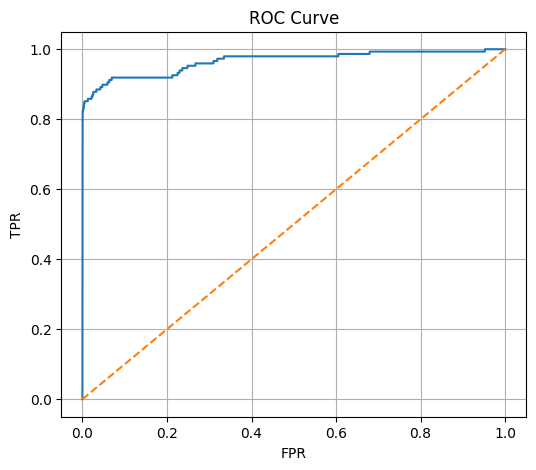

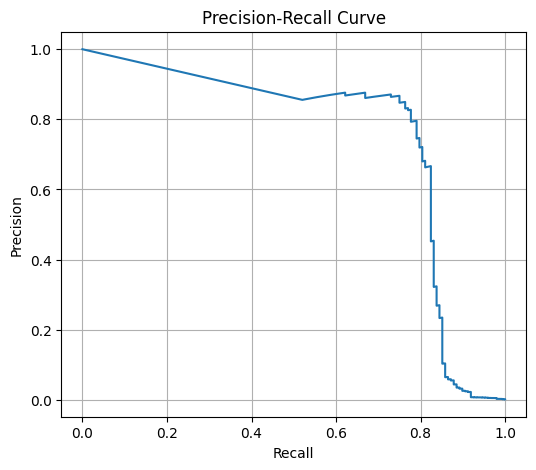

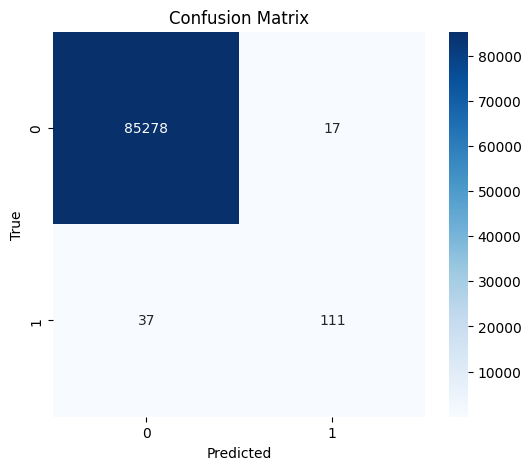

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_scores)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.grid(True); plt.show()

# PR Curve
prec, rec, _ = precision_recall_curve(y_test, test_scores)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.title("Precision-Recall Curve"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.grid(True); plt.show()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


In [34]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import json
from joblib import load
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import (
    confusion_matrix, roc_curve, precision_recall_curve
)

# Load model + metadata
model = load("artifacts/model.joblib")
with open("artifacts/metadata.json") as f:
    meta = json.load(f)

TH = meta["threshold"]
FEATS = meta["features"]

y_test = np.load("artifacts/y_test.npy")
test_scores = np.load("artifacts/test_scores.npy")
y_pred_test = (test_scores >= TH).astype(int)

# --------------------------------------------------
# 🌙 DARK THEME STYLES
# --------------------------------------------------
st.set_page_config(page_title="Fraud Detector", layout="wide")

dark_css = """
<style>
body {background-color: #0e1117 !important;}
[data-testid="stAppViewContainer"] {background-color: #0e1117;}
[data-testid="stSidebar"] {background-color: #111317;}
div, p, span, label {color: #e6e6e6 !important;}
h1, h2, h3, h4, h5 {color: #00eaff !important;}
.stButton button {
    background-color: #00eaff !important;
    color: black !important;
    border-radius: 6px;
    border: none;
    font-weight: bold;
}
</style>
"""
st.markdown(dark_css, unsafe_allow_html=True)

# --------------------------------------------------
# 🚀 APP LAYOUT
# --------------------------------------------------
st.title("💳 Credit Card Fraud Detection — Dark Mode Dashboard")

menu = st.sidebar.radio("Navigation", ["🔍 Single Prediction", "📂 Batch Prediction", "📊 Model Performance"])

# -------------------- SINGLE PREDICTION --------------------
if menu == "🔍 Single Prediction":
    st.subheader("Enter Transaction Details")

    inputs = {feat: st.number_input(feat, value=0.0) for feat in FEATS}

    if st.button("Predict Fraud Risk"):
        df = pd.DataFrame([inputs])
        score = float(model.predict_proba(df)[0][1])

        st.markdown("---")
        st.write(f"### Fraud Probability Score: **{score:.4f}**")

        # -------------------- RISK METER --------------------
        gauge = go.Figure(go.Indicator(
            mode="gauge+number",
            value=score * 100,
            title={'text': "Fraud Risk (%)", 'font': {'color': '#00eaff'}},
            gauge={
                'axis': {'range': [0, 100], 'tickcolor': 'white'},
                'bar': {'color': '#00eaff'},
                'steps': [
                    {'range': [0, 40], 'color': '#1a3d2f'},
                    {'range': [40, 70], 'color': '#704214'},
                    {'range': [70, 100], 'color': '#5c1414'}
                ],
                'threshold': {
                    'line': {'color': 'red', 'width': 4},
                    'thickness': 0.8,
                    'value': TH * 100
                }
            }
        ))
        st.plotly_chart(gauge, use_container_width=True)

        # -------------------- PREDICTION OUTPUT --------------------
        if score >= TH:
            st.markdown("<h2 style='color:#ff4d4d;'>🚨 Fraud Detected</h2>", unsafe_allow_html=True)
        else:
            st.markdown("<h2 style='color:#00eaff;'>✅ Legitimate Transaction</h2>", unsafe_allow_html=True)

# -------------------- BATCH PREDICTION --------------------
elif menu == "📂 Batch Prediction":
    st.subheader("Batch Fraud Detection (Upload CSV)")
    file = st.file_uploader("Upload CSV", type=["csv"])

    if file:
        data = pd.read_csv(file)
        scores = model.predict_proba(data[FEATS])[:,1]
        preds = (scores >= TH).astype(int)
        data["fraud_score"] = scores
        data["prediction"] = preds
        st.dataframe(data.head(20))

        st.download_button(
            "⬇️ Download Full Results",
            data.to_csv(index=False).encode("utf-8"),
            "fraud_predictions.csv",
            "text/csv"
        )

# -------------------- MODEL PERFORMANCE --------------------
else:
    st.subheader("Model Performance Metrics & Visualizations")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    fig1, ax1 = plt.subplots()
    sns.heatmap(cm, annot=True, cmap="cool", fmt="d", ax=ax1)
    ax1.set_title("Confusion Matrix")
    st.pyplot(fig1)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, test_scores)
    fig2, ax2 = plt.subplots()
    ax2.plot(fpr, tpr, color="#00eaff", linewidth=2)
    ax2.plot([0,1],[0,1],'--', color="gray")
    ax2.set_title("ROC Curve")
    st.pyplot(fig2)

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_test, test_scores)
    fig3, ax3 = plt.subplots()
    ax3.plot(rec, prec, color="#ffbf00", linewidth=2)
    ax3.set_title("Precision-Recall Curve")
    st.pyplot(fig3)


Overwriting app.py


In [37]:
# 🧱 Reinstall to ensure latest version
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared

# 🧠 Start Streamlit app silently
!streamlit run app.py --server.port 8501 &>/content/logs.txt &

import time, re

# 🌍 Start Cloudflared in background and capture the public URL
get_ipython().system_raw('./cloudflared tunnel --url http://localhost:8501 --no-autoupdate > /content/tunnel.log 2>&1 &')
time.sleep(5)

# ⏳ Wait a few seconds and extract the public URL
try:
    with open("/content/tunnel.log") as f:
        lines = f.read()
        url = re.search("https://[-0-9a-z]*\.trycloudflare\.com", lines).group(0)
        print("✅ Public URL:", url)
except:
    print("❌ Could not generate public URL. Try rerunning this cell after 10 seconds.")


✅ Public URL: https://orange-preference-jail-first.trycloudflare.com
